In [8]:
import kagglehub
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

# Download latest version
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
print("Path to dataset files:", path)

# Load CSVs using the correct path
train_data = pd.read_csv(f"{path}/sign_mnist_train.csv")
test_data = pd.read_csv(f"{path}/sign_mnist_test.csv")

# Separate labels and features
y_train = train_data["label"].values
y_test = test_data["label"].values

X_train = train_data.drop("label", axis=1).values
X_test = test_data.drop("label", axis=1).values

# Normalize and reshape
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=26)
y_test = to_categorical(y_test, num_classes=26)

print("Data loaded and preprocessed successfully!")

Path to dataset files: C:\Users\flori\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1
Data loaded and preprocessed successfully!


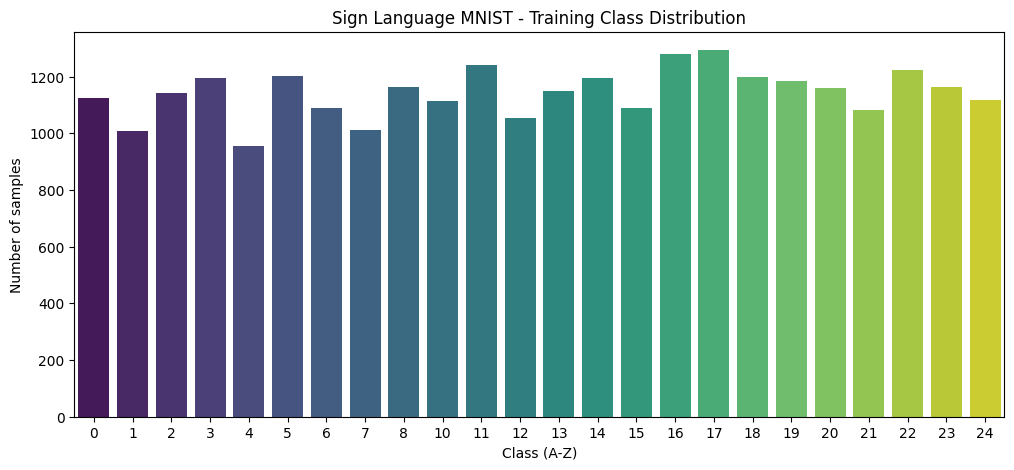

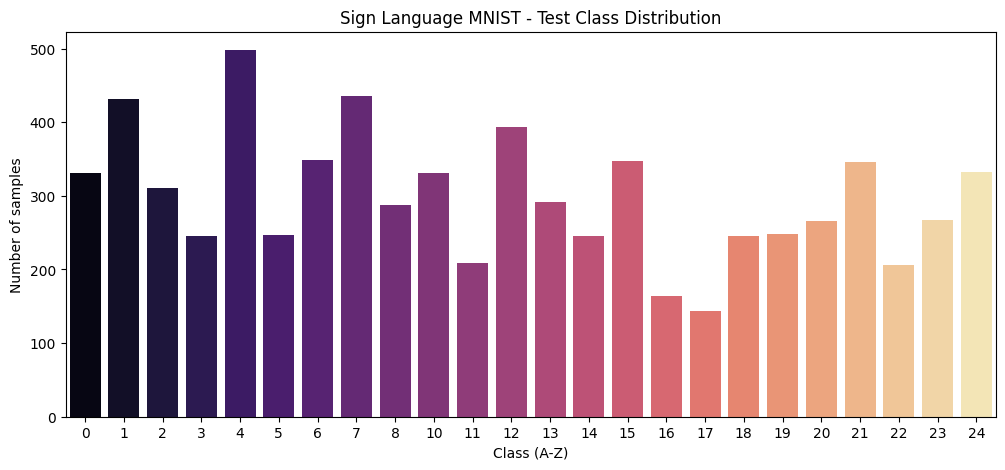

Class Distribution Report (Training & Test sets)
Class | Train Count | Train % | Test Count | Test %
  A   |    1126     |  4.10% |     331     |  4.62%
  B   |    1010     |  3.68% |     432     |  6.02%
  C   |    1144     |  4.17% |     310     |  4.32%
  D   |    1196     |  4.36% |     245     |  3.42%
  E   |     957     |  3.49% |     498     |  6.94%
  F   |    1204     |  4.39% |     247     |  3.44%
  G   |    1090     |  3.97% |     348     |  4.85%
  H   |    1013     |  3.69% |     436     |  6.08%
  I   |    1162     |  4.23% |     288     |  4.02%
  K   |    1114     |  4.06% |     331     |  4.62%
  L   |    1241     |  4.52% |     209     |  2.91%
  M   |    1055     |  3.84% |     394     |  5.49%
  N   |    1151     |  4.19% |     291     |  4.06%
  O   |    1196     |  4.36% |     246     |  3.43%
  P   |    1088     |  3.96% |     347     |  4.84%
  Q   |    1279     |  4.66% |     164     |  2.29%
  R   |    1294     |  4.71% |     144     |  2.01%
  S   |    1199

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

# Suppress Seaborn FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Convert one-hot labels back to integer for visualization
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Compute metrics
classes = sorted(set(y_train_labels))
train_counts = [np.sum(y_train_labels == c) for c in classes]
test_counts = [np.sum(y_test_labels == c) for c in classes]
train_percent = [count / len(y_train_labels) * 100 for count in train_counts]
test_percent = [count / len(y_test_labels) * 100 for count in test_counts]

# Plot training class distribution
plt.figure(figsize=(12, 5))
sns.countplot(x=y_train_labels, palette="viridis", hue=None, legend=False)
plt.title("Sign Language MNIST - Training Class Distribution")
plt.xlabel("Class (A-Z)")
plt.ylabel("Number of samples")
plt.show()

# Plot test class distribution
plt.figure(figsize=(12, 5))
sns.countplot(x=y_test_labels, palette="magma", hue=None, legend=False)
plt.title("Sign Language MNIST - Test Class Distribution")
plt.xlabel("Class (A-Z)")
plt.ylabel("Number of samples")
plt.show()

# Print textual report
print("Class Distribution Report (Training & Test sets)")
print("Class | Train Count | Train % | Test Count | Test %")
for c, tc, tp, tec, tep in zip(
    classes, train_counts, train_percent, test_counts, test_percent
):
    print(
        f"  {chr(c+65)}   |    {tc:4d}     | {tp:5.2f}% |    {tec:4d}     | {tep:5.2f}%"
    )

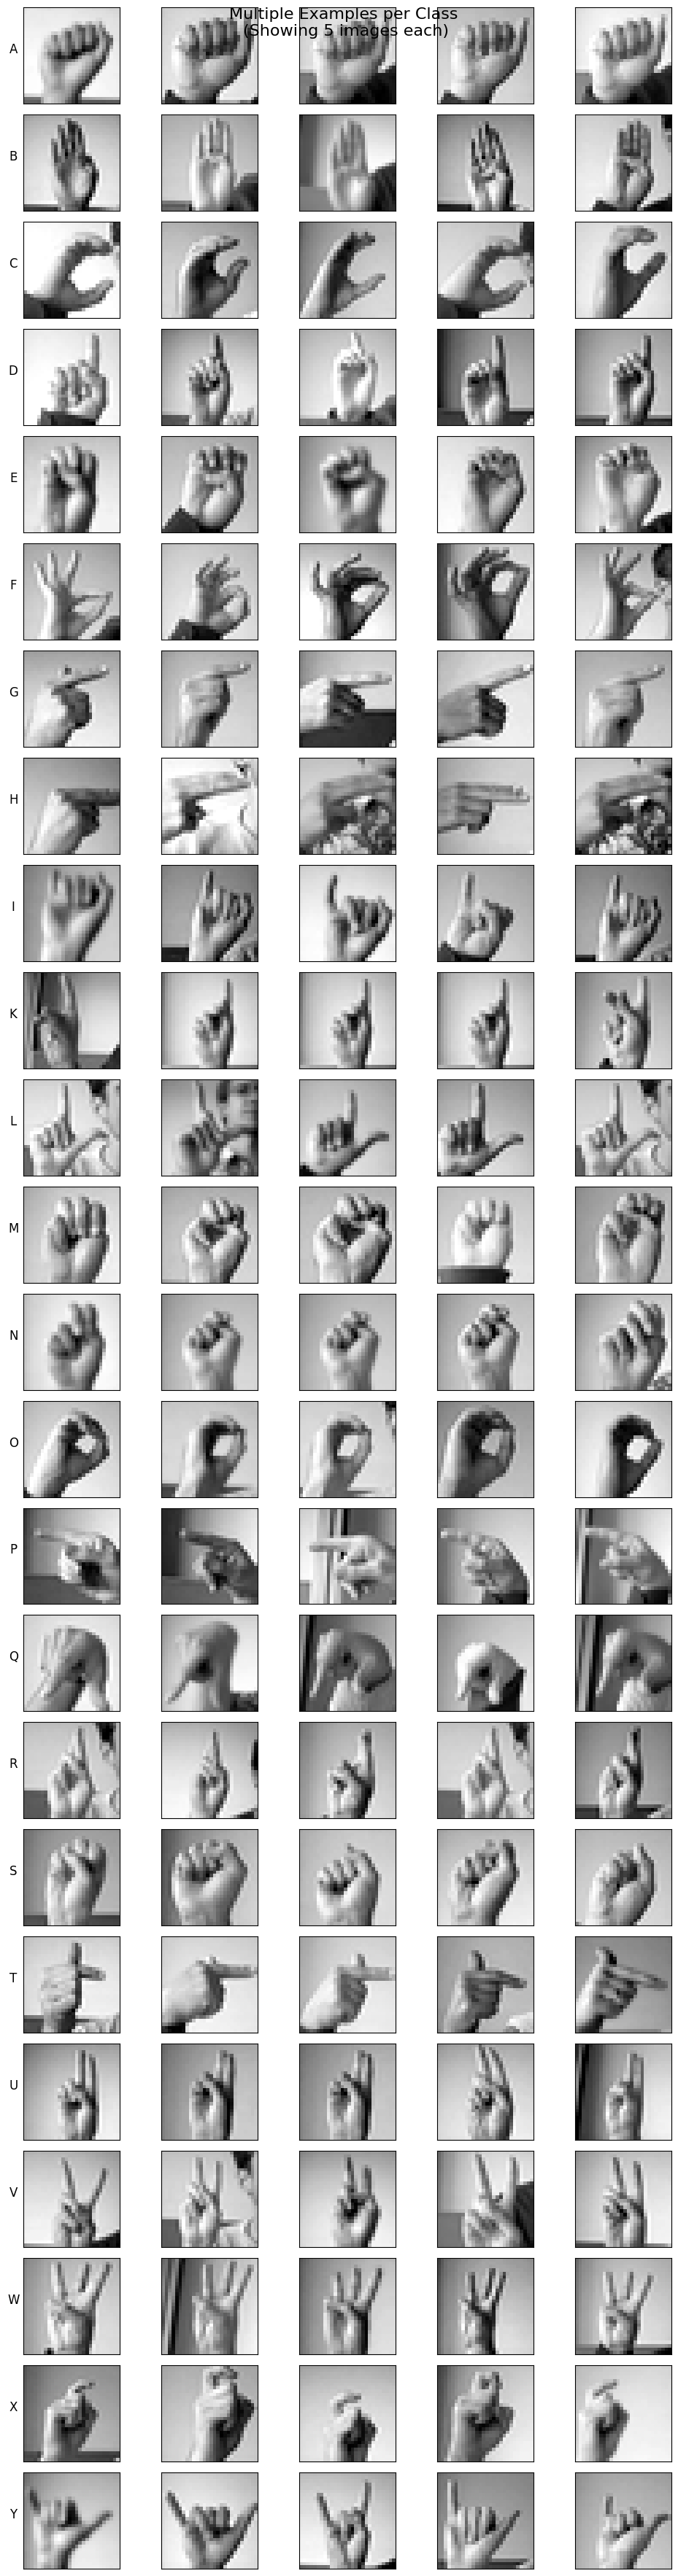

In [10]:
# Number of examples per class to show
examples_per_class = 5

# Get unique classes
classes = sorted(set(y_train_labels))

plt.figure(figsize=(examples_per_class * 2, len(classes) * 1.5))

plot_idx = 1
for c in classes:
    # Get indices of all samples for class c
    class_indices = np.where(y_train_labels == c)[0]
    # Randomly sample examples_per_class images
    sampled_indices = np.random.choice(class_indices, examples_per_class, replace=False)

    for i, idx in enumerate(sampled_indices):
        plt.subplot(len(classes), examples_per_class, plot_idx)
        plt.imshow(X_train[idx].reshape(28, 28), cmap="gray")
        if i == 0:
            plt.ylabel(chr(c + 65), rotation=0, labelpad=10, fontsize=12)
        plt.xticks([])
        plt.yticks([])
        plot_idx += 1

plt.suptitle(
    f"Multiple Examples per Class \n(Showing {examples_per_class} images each)",
    fontsize=16,
)
plt.tight_layout()
plt.show()

# Model Description
The program downloads and preprocesses the Sign Language MNIST dataset, then builds, trains, and evaluates multiple neural network classifiers for recognizing hand-sign images. It trains both a dense baseline model and several convolutional neural networks with different optimizers, using early stopping to prevent overfitting. Training time and best validation accuracy are automatically logged, model performance is evaluated on a test set, results are summarized in a comparison table, and the trained models are saved for later use.

In [11]:
import kagglehub
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import time
from functools import wraps
import os
import json

# -----------------------
# Constants
INVALID_LABELS = {9, 25}  # J and Z
NUM_CLASSES = 24
INPUT_SHAPE = (28, 28, 1)

# -----------------------
# Decorator to log training
def log_training(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        self = args[0]
        print(f"\nStarting training for {self.model_name}...")
        start = time.time()
        history = func(*args, **kwargs)
        print(f"Finished training {self.model_name} in {time.time()-start:.2f}s")
        print(f"Best validation accuracy: {self.best_val_acc:.4f}\n")
        return history
    return wrapper

# -----------------------
# ASL Model Class
class ASLModel:
    def __init__(self, model_name="Model"):
        self.model_name = model_name
        self.model = None
        self.history = None
        self.early_stop = EarlyStopping(
            monitor="val_loss", patience=2, restore_best_weights=True
        )

    def build_dense(self):
        self.model = Sequential([
            Flatten(input_shape=INPUT_SHAPE),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(NUM_CLASSES, activation="softmax")
        ])
        self.model.compile(
            optimizer=Adam(),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

    def build_cnn(
        self,
        conv_layers=[(16,(3,3),(2,2)), (32,(3,3),(2,2))],
        dense_layers=[64],
        optimizer="adam",
        use_dropout=True,
        use_batchnorm=True,
        l2_reg=0.005
    ):
        self.model = Sequential()

        for i, (filters, kernel, pool) in enumerate(conv_layers):
            self.model.add(Conv2D(
                filters, kernel,
                activation="relu",
                input_shape=INPUT_SHAPE if i == 0 else None,
                kernel_regularizer=l2(l2_reg)
            ))
            if use_batchnorm:
                self.model.add(BatchNormalization())
            self.model.add(MaxPooling2D(pool))

        self.model.add(Flatten())

        for units in dense_layers:
            self.model.add(Dense(units, activation="relu", kernel_regularizer=l2(l2_reg)))
            if use_dropout:
                self.model.add(Dropout(0.6))

        self.model.add(Dense(NUM_CLASSES, activation="softmax"))

        opt = {"adam": Adam(), "sgd": SGD(), "rmsprop": RMSprop()}[optimizer]
        self.model.compile(
            optimizer=opt,
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

    @log_training
    def train(self, X_train, y_train, X_val, y_val, epochs=5, batch_size=64):
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[self.early_stop],
            verbose=1
        )
        return self.history

    def evaluate(self, X, y):
        return self.model.evaluate(X, y, verbose=0)

    @property
    def best_val_acc(self):
        return max(self.history.history["val_accuracy"])

    def save(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        self.model.save(path)

# -----------------------
# Load and preprocess data
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
train_df = pd.read_csv(f"{path}/sign_mnist_train.csv")
test_df  = pd.read_csv(f"{path}/sign_mnist_test.csv")

# Remove J and Z
train_df = train_df[~train_df["label"].isin(INVALID_LABELS)]
test_df  = test_df[~test_df["label"].isin(INVALID_LABELS)]

# Remap labels to 0–23
label_map = {old: new for new, old in enumerate(
    sorted(set(range(26)) - INVALID_LABELS)
)}

y_train = train_df["label"].map(label_map).values
y_test  = test_df["label"].map(label_map).values

X_train = train_df.drop("label", axis=1).values.reshape(-1,28,28,1) / 255.0
X_test  = test_df.drop("label", axis=1).values.reshape(-1,28,28,1) / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test  = to_categorical(y_test, NUM_CLASSES)

# -----------------------
# Train Dense Model
dense_model = ASLModel("Dense Model")
dense_model.build_dense()
dense_model.train(X_train, y_train, X_test, y_test)

# -----------------------
# Train CNN Models
optimizers = ["adam", "sgd", "rmsprop"]
cnn_models = {}

for opt in optimizers:
    cnn = ASLModel(f"CNN ({opt})")
    cnn.build_cnn(optimizer=opt)
    cnn.train(X_train, y_train, X_test, y_test)
    cnn_models[opt] = cnn

# -----------------------
# Model comparison
comparison = [{
    "Model": dense_model.model_name,
    "Test Accuracy": dense_model.evaluate(X_test, y_test)[1]
}]

for cnn in cnn_models.values():
    comparison.append({
        "Model": cnn.model_name,
        "Test Accuracy": cnn.evaluate(X_test, y_test)[1]
    })

df = pd.DataFrame(comparison).sort_values("Test Accuracy", ascending=False)
print("\nModel Comparison Table:")
print(df)

# -----------------------
# Save models
dense_model.save("src/ASL-classifier-model/asl_dense_model.h5")
cnn_models["adam"].save("src/ASL-classifier-model/asl_cnn_adam.h5")
cnn_models["sgd"].save("src/ASL-classifier-model/asl_cnn_sgd.h5")
cnn_models["rmsprop"].save("src/ASL-classifier-model/asl_cnn_rmsprop.h5")


C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Starting training for Dense Model...
Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3251 - loss: 2.2554 - val_accuracy: 0.4741 - val_loss: 1.7567
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5881 - loss: 1.3077 - val_accuracy: 0.5474 - val_loss: 1.4591
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6874 - loss: 0.9678 - val_accuracy: 0.6405 - val_loss: 1.2065
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7635 - loss: 0.7466 - val_accuracy: 0.6336 - val_loss: 1.1768
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8149 - loss: 0.5930 - val_accuracy: 0.6753 - val_loss: 1.0894
Finished training Dense Model in 12.87s
Best validation accuracy: 0.6753


Starting training for CNN (adam)...


C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5371 - loss: 2.0727 - val_accuracy: 0.5906 - val_loss: 1.9333
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8737 - loss: 0.7996 - val_accuracy: 0.8657 - val_loss: 0.7905
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9367 - loss: 0.5037 - val_accuracy: 0.8915 - val_loss: 0.5969
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9558 - loss: 0.3793 - val_accuracy: 0.9219 - val_loss: 0.4608
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9648 - loss: 0.3175 - val_accuracy: 0.9144 - val_loss: 0.4498
Finished training CNN (adam) in 60.32s
Best validation accuracy: 0.9219


Starting training for CNN (sgd)...
Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.3362 - loss: 2.8946 - val_accuracy: 0.5390 - val_loss: 2.5827
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6145 - loss: 1.8411 - val_accuracy: 0.7924 - val_loss


Model Comparison Table:
           Model  Test Accuracy
3  CNN (rmsprop)       0.921640
1     CNN (adam)       0.914389
2      CNN (sgd)       0.880089
0    Dense Model       0.675265


# Lab 2

The original procedural script was refactored into a modular, object-oriented pipeline that cleanly separates data handling, model construction, training, and evaluation. Training is now monitored with a decorator and early stopping to reduce overfitting, CNN architectures are fully configurable, and both dense and CNN models are evaluated consistently. The final version also automatically compares models and reports performance, making experimentation clearer, safer, and easier to extend.


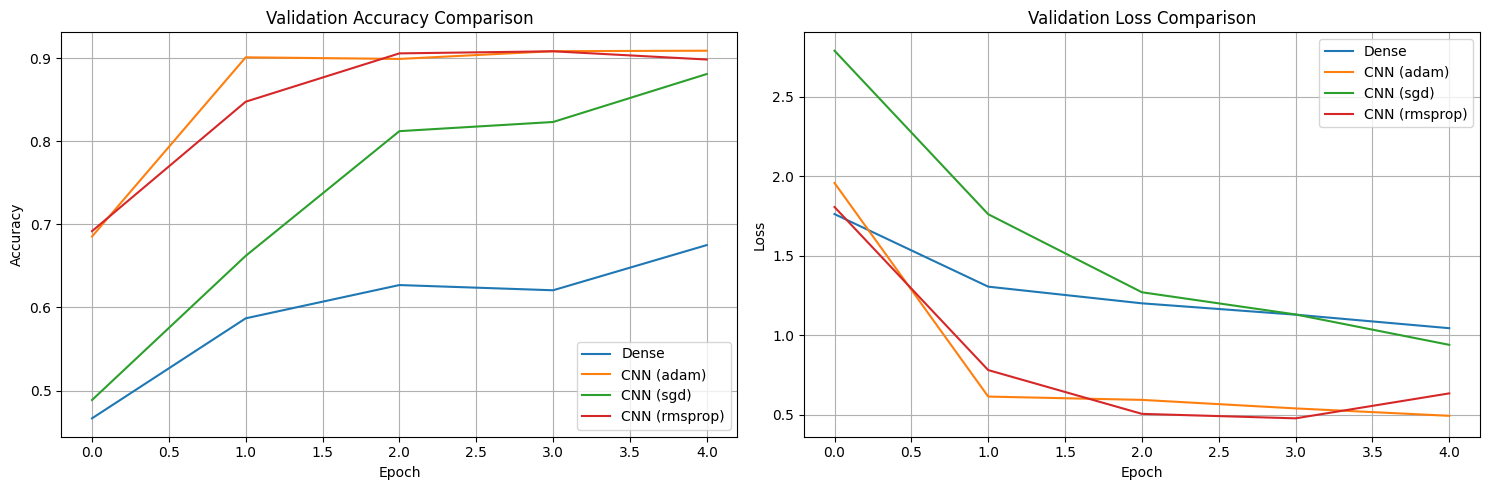

In [12]:
import os
import matplotlib.pyplot as plt

# -----------------------
# Load histories from JSON
history_files = {
    "Dense": "src/ASL-classifier-model/dense_history.json",
    "CNN (adam)": "src/ASL-classifier-model/cnn_adam_history.json",
    "CNN (sgd)": "src/ASL-classifier-model/cnn_sgd_history.json",
    "CNN (rmsprop)": "src/ASL-classifier-model/cnn_rmsprop_history.json",
}

histories = {}
for name, path in history_files.items():
    if os.path.exists(path):
        with open(path, "r") as f:
            histories[name] = json.load(f)
    else:
        print(f"Warning: history file {path} not found.")

# -----------------------
# Plot Validation Accuracy and Loss
plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if "val_accuracy" in h:
        plt.plot(h["val_accuracy"], label=name)
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss comparison
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if "val_loss" in h:
        plt.plot(h["val_loss"], label=name)
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Summmary of Changes
At this phase in the project, the ASL classifier model could 
easily become an ensemble model if the predictors were combined.
Since there are three versions of the CNN and one Dense model, 
the best performing predictors could be combined using majority 
class or averaging probabilities for a some class from within the
set. Useful overfitting is applied in the use of dropout, batch
normalization, and L2 Regularization as a strategy to mitigate 
the risk of overfitting for such a relatively small dataset. 
The best choice for a new design pattern to implement in this case 
is the Ensemble Design pattern, which will combine results from the 
best performing models in the experiment to make better predictions 
about which images represent which letter. Since one model(Dense) 
showed bad performance, and another displayed signs of model 
instability(Adam), those two will be left out; but the remaining 
results from the SGD and MSPROP Convolutional Neural Networks will 
be combined into an ensemble model. 

In [16]:
from scipy.stats import mode
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# -----------------------
# EnsembleModel Class (compatible with ASLModel wrapper)
class EnsembleModel:
    def __init__(self, asl_models, model_names=None):
        """
        asl_models: list of trained ASLModel instances
        model_names: optional list of names for reporting
        """
        self.asl_models = asl_models
        self.model_names = model_names if model_names else [m.model_name for m in asl_models]

    def predict_proba(self, X):
        """
        Returns a list of predicted probabilities from all models
        """
        return [m.model.predict(X, verbose=0) for m in self.asl_models]

    def predict_majority_vote(self, X):
        """
        Returns predictions using majority voting across models
        """
        probs_list = self.predict_proba(X)
        class_preds = [np.argmax(probs, axis=1) for probs in probs_list]
        stacked_preds = np.vstack(class_preds)
        majority_preds = mode(stacked_preds, axis=0).mode[0]
        return majority_preds

    def predict_average_probs(self, X):
        """
        Returns predictions using average of probabilities across models
        """
        probs_list = self.predict_proba(X)
        avg_probs = np.mean(np.stack(probs_list, axis=0), axis=0)
        avg_preds = np.argmax(avg_probs, axis=1)
        return avg_preds

    def evaluate(self, X, y):
        """
        Evaluates both ensemble methods and returns a comparison DataFrame
        """
        y_true = np.argmax(y, axis=1)

        majority_preds = self.predict_majority_vote(X)
        majority_acc = np.mean(majority_preds == y_true)

        avg_preds = self.predict_average_probs(X)
        avg_acc = np.mean(avg_preds == y_true)

        # Individual model accuracies for reference
        individual_accs = {}
        for name, m in zip(self.model_names, self.asl_models):
            acc = np.mean(np.argmax(m.model.predict(X, verbose=0), axis=1) == y_true)
            individual_accs[name] = acc

        # Comparison table
        results = pd.DataFrame({
            "Model": list(self.model_names) + ["Ensemble (Majority Vote)", "Ensemble (Prob Average)"],
            "Accuracy": list(individual_accs.values()) + [majority_acc, avg_acc]
        }).sort_values(by="Accuracy", ascending=False)

        return results

# -----------------------
# -----------------------
# Ensemble usage with all four models
ensemble_models = [
    dense_model,           # Dense Model
    cnn_models["adam"],    # CNN (Adam)
    cnn_models["sgd"],     # CNN (SGD)
    cnn_models["rmsprop"]  # CNN (RMSprop)
]
ensemble_names = [m.model_name for m in ensemble_models]

# Create Ensemble
ensemble = EnsembleModel(ensemble_models, ensemble_names)

# Evaluate
comparison_df = ensemble.evaluate(X_test, y_test)

print("\nEnsemble Comparison Table:")
print(comparison_df)



Ensemble Comparison Table:
                      Model  Accuracy
5   Ensemble (Prob Average)  0.936419
3             CNN (rmsprop)  0.921640
1                CNN (adam)  0.914389
2                 CNN (sgd)  0.880089
0               Dense Model  0.675265
4  Ensemble (Majority Vote)  0.048522


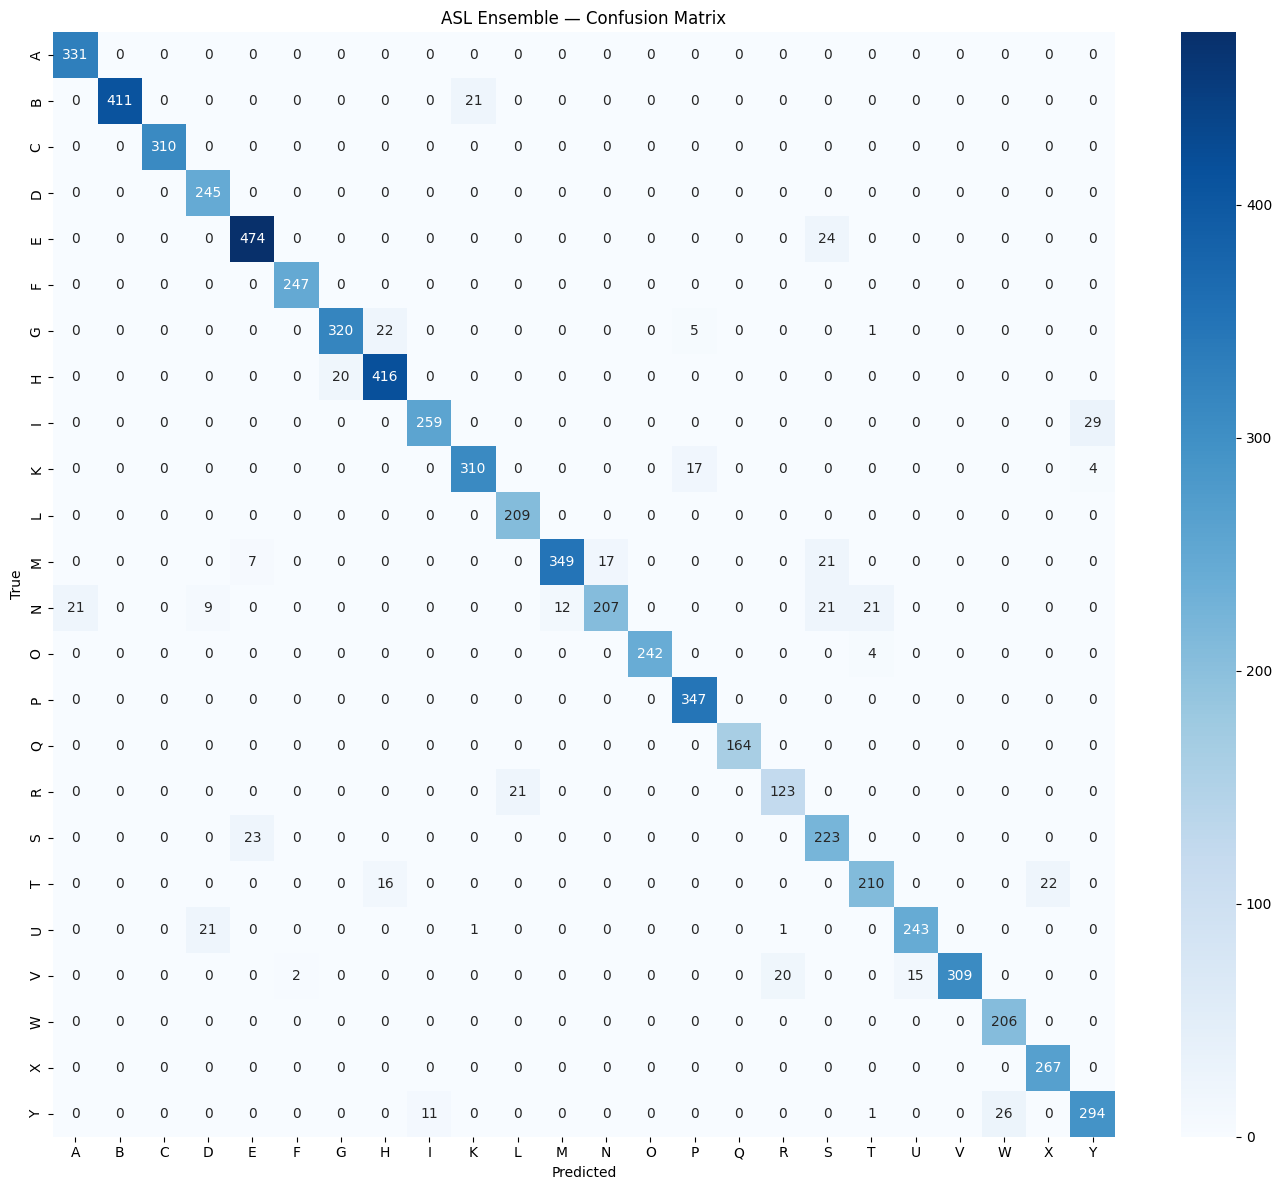

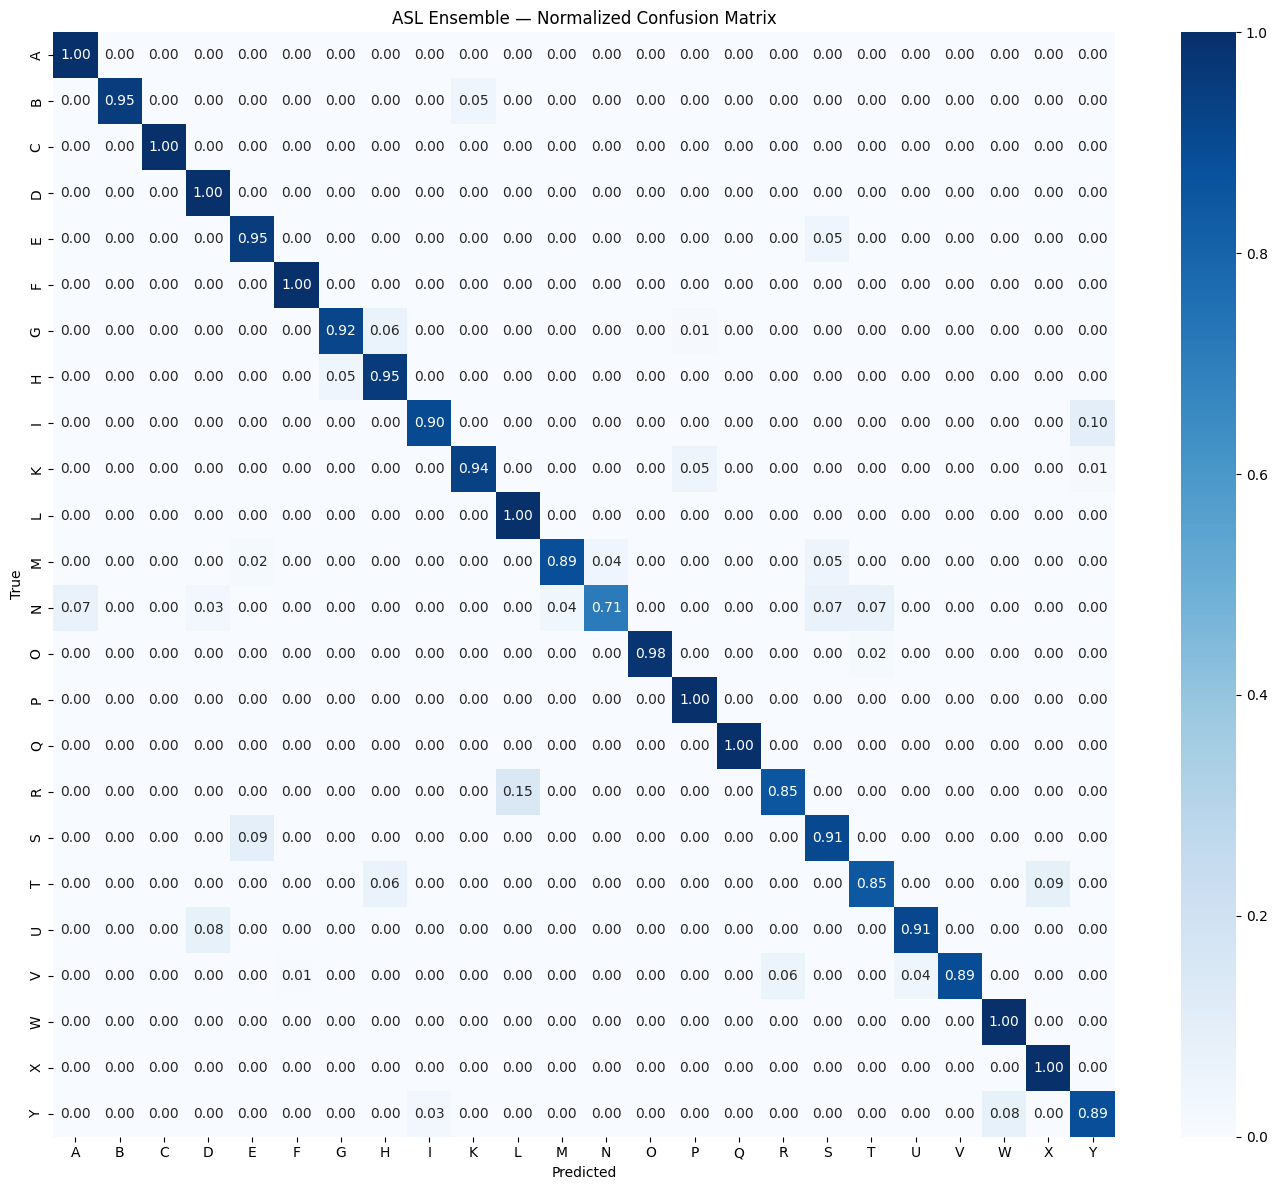


Per-class Precision / Recall / F1:


,precision,recall,f1-score
C,1.000000,1.000000,1.000000
Q,1.000000,1.000000,1.000000
F,0.991968,1.000000,0.995968
O,1.000000,0.983740,0.991803
B,1.000000,0.951389,0.975089
P,0.940379,1.000000,0.969274
A,0.940341,1.000000,0.969253
X,0.923875,1.000000,0.960432
L,0.908696,1.000000,0.952164
E,0.940476,0.951807,0.946108



Top Confusion Pairs:


,True,Predicted,Count
6,I,Y,29
30,Y,W,26
1,E,S,24
19,S,E,23
21,T,X,22
2,G,H,22
0,B,K,21
15,N,S,21
16,N,T,21
18,R,L,21


In [18]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

# -------------------------------------------------
# Ensemble probability averaging
def ensemble_predict_proba(asl_models, X):
    """
    asl_models: list of ASLModel instances
    """
    probs = [m.model.predict(X, verbose=0) for m in asl_models]
    return np.mean(np.stack(probs, axis=0), axis=0)

# -------------------------------------------------
# Full ensemble evaluation + visualization
def analyze_ensemble(
    asl_models,
    X,
    y_true,
    class_names,
    title_prefix="Ensemble (Probability Averaging)"
):
    # True / predicted labels
    y_true_labels = np.argmax(y_true, axis=1)
    avg_probs = ensemble_predict_proba(asl_models, X)
    y_pred_labels = np.argmax(avg_probs, axis=1)

    # -------------------------------------------------
    # Confusion matrix (raw)
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title_prefix} — Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # -------------------------------------------------
    # Confusion matrix (normalized)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title_prefix} — Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # -------------------------------------------------
    # Per-class metrics
    report = classification_report(
        y_true_labels,
        y_pred_labels,
        target_names=class_names,
        output_dict=True
    )

    metrics_df = (
        pd.DataFrame(report)
        .transpose()
        .iloc[:-3][["precision", "recall", "f1-score"]]
        .sort_values("f1-score", ascending=False)
    )

    print("\nPer-class Precision / Recall / F1:")
    display(metrics_df)

    # -------------------------------------------------
    # Top confusion pairs (excluding correct predictions)
    confusion_pairs = []

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append({
                    "True": class_names[i],
                    "Predicted": class_names[j],
                    "Count": cm[i, j]
                })

    confusion_df = (
        pd.DataFrame(confusion_pairs)
        .sort_values("Count", ascending=False)
        .head(10)
    )

    print("\nTop Confusion Pairs:")
    display(confusion_df)

    return metrics_df, confusion_df

# -------------------------------------------------
# USAGE
# -------------------------------------------------

# Models used for probability averaging
ensemble_models = [
    dense_model,
    cnn_models["adam"],
    cnn_models["sgd"],
    cnn_models["rmsprop"]
]

# Class labels: A–Z excluding J and Z
class_names = [chr(i + 65) for i in sorted(set(range(26)) - {9, 25})]

# Run full analysis
metrics_df, top_confusions = analyze_ensemble(
    asl_models=ensemble_models,
    X=X_test,
    y_true=y_test,
    class_names=class_names,
    title_prefix="ASL Ensemble"
)


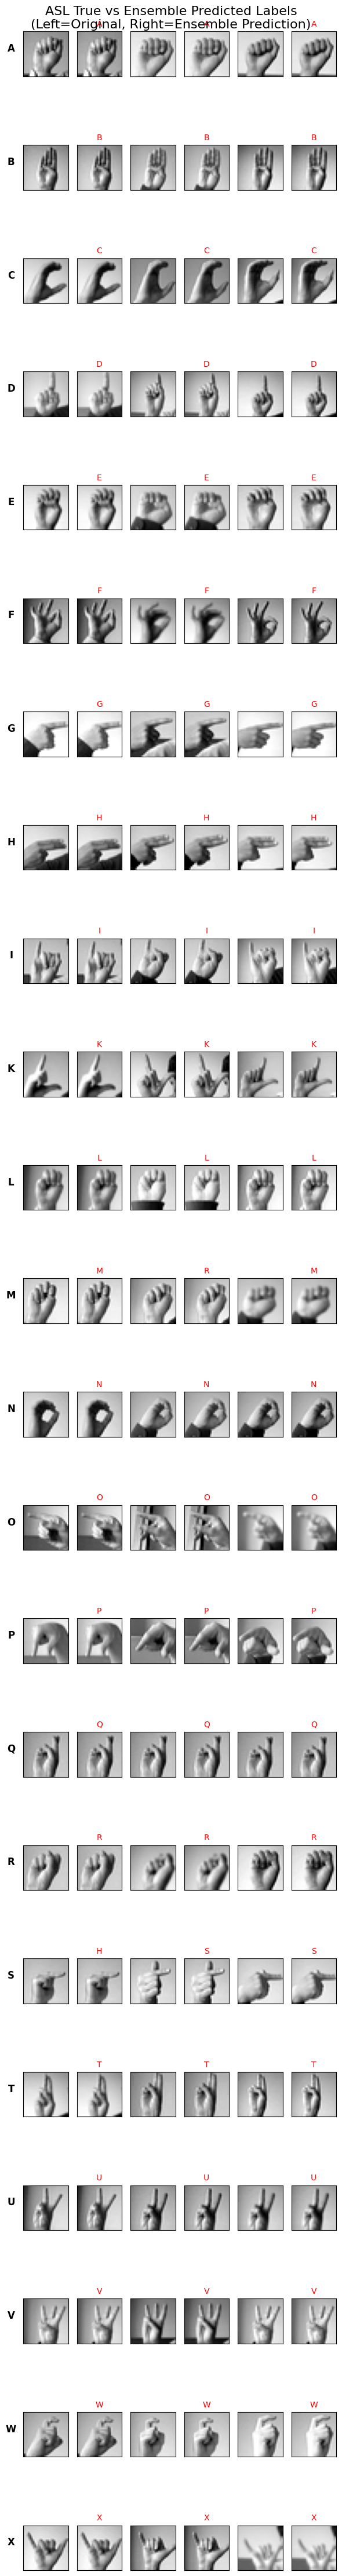

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
examples_per_class = 3
class_indices_set = sorted(set(range(26)) - {9, 25})  # Exclude J (9) and Z (25)
class_names = [chr(i + 65) for i in class_indices_set]

# True labels
y_test_labels = np.argmax(y_test, axis=1)

plt.figure(figsize=(examples_per_class * 2, len(class_names) * 2))

plot_idx = 1
for class_idx, letter in zip(class_indices_set, class_names):
    # get indices of all samples with this TRUE label
    class_indices = np.where(y_test_labels == class_idx)[0]

    # randomly sample examples_per_class
    sampled_indices = np.random.choice(
        class_indices,
        size=min(examples_per_class, len(class_indices)),
        replace=False
    )

    for i, idx in enumerate(sampled_indices):
        # -------------------
        # Left: Original Image
        plt.subplot(len(class_names), examples_per_class*2, plot_idx)
        plt.imshow(X_test[idx].reshape(28,28), cmap="gray")
        if i == 0:
            plt.ylabel(letter, rotation=0, labelpad=15, fontsize=12, weight="bold")
        plt.xticks([])
        plt.yticks([])
        plot_idx += 1

        # -------------------
        # Right: Ensemble Predicted Label
        plt.subplot(len(class_names), examples_per_class*2, plot_idx)
        pred_idx = ensemble.predict_average_probs(X_test[idx:idx+1])[0]
        pred_letter = chr(pred_idx + 65)
        plt.imshow(X_test[idx].reshape(28,28), cmap="gray")
        plt.title(pred_letter, fontsize=10, color="red")
        plt.xticks([])
        plt.yticks([])
        plot_idx += 1

plt.suptitle(
    f"ASL True vs Ensemble Predicted Labels\n(Left=Original, Right=Ensemble Prediction)",
    fontsize=16
)
plt.tight_layout()
plt.show()
